In [1]:
%reload_ext autoreload
%autoreload 2

import os

from rocket_fft import numpy_like

numpy_like()

os.environ['NUMEXPR_MAX_THREADS'] = '20'
os.environ['NUMBA_DEBUGINFO'] = '0'

from alphadia.extraction import processlogger
processlogger.init_logging()
import logging

logger = logging.getLogger()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neptune.new as neptune

from alphabase.spectral_library.base import SpecLibBase

from alphadia.extraction.planning import Plan, Workflow
from alphadia.extraction.calibration import RunCalibration
from alphadia.extraction.candidateselection import MS1CentricCandidateSelection
from alphadia.extraction.scoring import fdr_correction, MS2ExtractionWorkflow
from alphadia.extraction import utils

yaml_file = 'config.yaml'

library = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/21min_Evosep_HeLa_BR14_48fractions_diaPASEF_py_diAID_2_egs.hdf'
raw_files = ['/Users/georgwallmann/Documents/data/alphadia_benchmarking/raw_data/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_diaPASEF_S4-A1_1_500.d']

output_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs'

try:
    neptune_token = os.environ['NEPTUNE_TOKEN']
except KeyError:
    logger.error('NEPTUNE_TOKEN environtment variable not set')


0:00:02.200085  WARNING: WARNING: Temp mmap arrays are written to /var/folders/lc/9594t94d5b5_gn0y04w1jh980000gn/T/temp_mmap_9bc00e9c. Cleanup of this folder is OS dependant, and might need to be triggered manually! Current space: 799,394,004,992
0:00:02.200562  WARNING: WARNING: No Bruker libraries are available for this operating system. Mobility and m/z values need to be estimated. While this estimation often returns acceptable results with errors < 0.02 Th, huge errors (e.g. offsets of 6 Th) have already been observed for some samples!
0:00:02.200758  INFO: 


In [2]:
test_lib = SpecLibBase()
test_lib.load_hdf(library, load_mod_seq=True)

plan = Plan(raw_files, config_update = 
    {'extraction':
        {
            'target_mobility_tolerance': 0.05,
            'target_rt_tolerance': 90,
            'batch_size' : 2000,
            'recalibration_target' : 100
        }
    }
    
)
plan.from_spec_lib_base(test_lib)
for dia_data, precursors_flat, fragments_flat in plan.get_run_data():

    workflow = Workflow(
        plan.config, 
        dia_data, 
        precursors_flat, 
        fragments_flat
        )

    #workflow.calibration()

0:00:07.528526  PROGRESS:       _   _      _         ___ ___   _   
0:00:07.529003  PROGRESS:      /_\ | |_ __| |_  __ _|   \_ _| /_\  
0:00:07.529245  PROGRESS:     / _ \| | '_ \ ' \/ _` | |) | | / _ \ 
0:00:07.529427  PROGRESS:    /_/ \_\_| .__/_||_\__,_|___/___/_/ \_\
0:00:07.529667  PROGRESS:            |_|                            
0:00:07.529850  PROGRESS: 
0:00:07.531508  INFO: loading default config from /Users/georgwallmann/Documents/git/alphadia/alphadia/extraction/../../misc/config/default.yaml
0:00:07.537658  INFO: Applying config update from dict
0:00:07.537959  PROGRESS: version: 1.0.2
0:00:07.538187  PROGRESS: hostname: Georgs-MBP.fritz.box
0:00:07.538397  PROGRESS: date: 2023-04-26 00:15:07
0:00:13.634405  INFO: renaming precursor_columns columns
0:00:13.635438  INFO: renaming fragment_columns columns
0:00:13.635781  INFO: ========= Library Stats =========
0:00:13.636000  INFO: Number of precursors: 460,153
0:00:13.693165  INFO: 	thereof targets:230,483
0:00:13.693669

In [ ]:
output_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs/2023_04_20_parameter_optimization'

In [ ]:
precursors_flat.to_csv(os.path.join(output_location, 'precursors_flat.csv'))
fragments_flat.to_csv(os.path.join(output_location, 'fragments_flat.csv'))

In [3]:
precursors_flat = pd.read_csv('/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs/2023_04_20_parameter_optimization/precursors_flat.csv')
fragments_flat = pd.read_csv('/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs/2023_04_20_parameter_optimization/fragments_flat.csv')

In [ ]:
benchmark_results = []

In [ ]:
#elution_groups = precursors_flat['elution_group_idx'].unique()
#elution_group_sample = elution_groups[np.random.choice(len(elution_groups), n_samples, replace=False)]

precursors_sample = precursors_flat[precursors_flat['precursor_idx'].isin([2,9851,1])]

In [5]:
precursors_flat = precursors_flat.sort_values(by=['precursor_idx'])

In [6]:
from alphadia.extraction import hybridselection
from alphadia.extraction import scoring
from alphadia.extraction import quadrupole

n_samples = 10000

for i in range(1):

    

    config = hybridselection.HybridCandidateConfig()
    

    config.update({
        'rt_tolerance':150.,
        'mobility_tolerance': 0.06,
        'candidate_count': 5,
        'mz_tolerance': 15,
        'sigma_scale_rt': 0.1,
        'peak_len_mobility': 0.01,
        'sigma_scale_mobility': 1,
        'min_size_rt': 3,
        'min_size_mobility': 8,
        'f_mobility': 1.0,
        'center_fraction': 0.2
    })

    extraction = hybridselection.HybridCandidateSelection(
        dia_data,
        precursors_flat,
        fragments_flat,
        config.jitclass(),
        rt_column = f'rt_calibrated',
        mobility_column = f'mobility_calibrated',
        precursor_mz_column = f'mz_calibrated',
        fragment_mz_column = f'mz_calibrated',
        debug=False,
        mz_tolerance = 15,
        thread_count=10,
        #feature_path='/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs/2023_04_20_parameter_optimization'
    )
    egs = extraction()




0:01:04.414153  INFO: Duty cycle consists of 13 frames, 1.39 seconds cycle time
0:01:04.414726  INFO: Duty cycle consists of 928 scans, 0.00065 1/K_0 resolution
0:01:04.415140  INFO: Expected peak length in RT is 10.00 seconds, sigma is 0.36
0:01:04.415408  INFO: Expected peak length in mobility is 0.01 1/K_0, sigma is 7.73
100%|██████████| 460152/460152 [31:42<00:00, 241.88it/s] 


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/georgwallmann/Documents/git/alphatims/alphatims/utils.py:583: NumbaTypeSafetyWarning: unsafe cast from float64 to float32. Precision may be lost.
  numba_func(i, *args)
/Users/georgwallmann/Documents/git/alphatims/alphatims/utils.py:583: NumbaTypeSafetyWarning: unsafe cast from int64 to float32. Precision may be lost.
  numba_func(i, *args)
100%|██████████| 1757963/1757963 [03:00<00:00, 9735.59it/s] 
0:59:44.132179  INFO: Scored 1757963 candidates
0:59:44.639316  INFO: 3.62% of targets failed, 5.15% of decoys failed


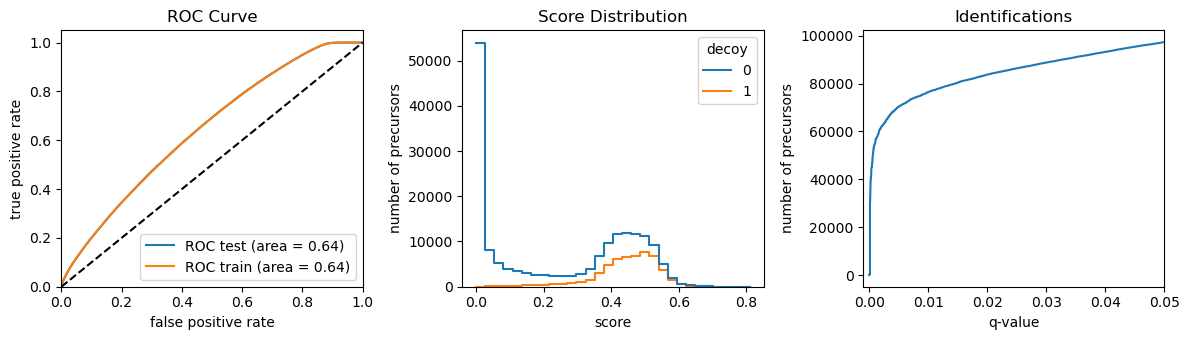

In [8]:
quad = quadrupole.SimpleQuadrupole(dia_data.cycle)

extraction = MS2ExtractionWorkflow(
    dia_data,
    precursors_flat,
    fragments_flat,
    egs,
    debug=False,
    quadrupole_calibration = quad,
    rt_column = 'rt_calibrated',
    mobility_column = 'mobility_calibrated',
    precursor_mz_column = 'mz_calibrated',
    fragment_mz_column = 'mz_calibrated',
    precursor_mz_tolerance = 15,
    fragment_mz_tolerance = 15,
    thread_count=10
)
features_df, fragments_df = extraction()

psm_df = scoring.fdr_correction(features_df, )

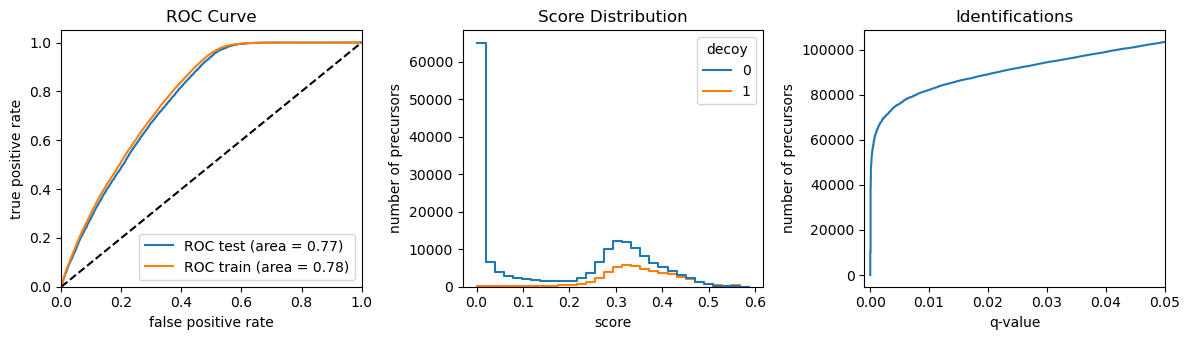

In [43]:
psm_df = scoring.fdr_correction(psm_df, )

In [44]:
(psm_df['qval'] <= 0.01).sum()

82133

In [30]:
df_sig = psm_df[psm_df['qval'] <= 0.01]

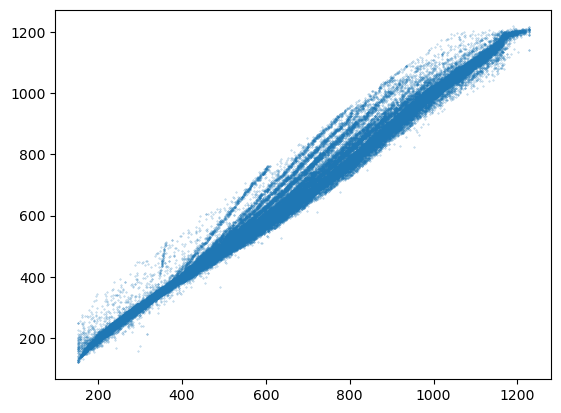

In [35]:
plt.scatter(df_sig['rt_calibrated'], df_sig['rt_observed'], s=0.1, alpha=0.5)

In [9]:
psm_df.to_csv('/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs/2023_04_20_parameter_optimization/_optimization_psm_df.tsv', sep='\t')

In [10]:
feature_matrix = np.load('/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs/2023_04_20_parameter_optimization/features.npy')
feature_df = pd.read_csv('/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs/2023_04_20_parameter_optimization/candidates.tsv', sep='\t')

In [11]:
feature_matrix.shape

(1769148, 12)

In [12]:
matrix_df = pd.DataFrame(feature_matrix, columns=[f'f{i}' for i in range(feature_matrix.shape[1])])

In [14]:
# stack feature_df and matrix_df column wise
feature_df = pd.concat([feature_df, matrix_df], axis=1)

In [16]:
feature_df['key'] = feature_df['precursor_idx'].astype(str) + '_' + feature_df['rank'].astype(str)

In [17]:
psm_df['key'] = psm_df['precursor_idx'].astype(str) + '_' + psm_df['rank'].astype(str)

In [18]:
feature_df = feature_df[feature_df['key'].isin(psm_df['key'])]

In [22]:
feature_df = feature_df.merge(psm_df[['qval','key']], on='key', how='left')

In [28]:
feature_sig_df = feature_df[(feature_df['qval'] <= 0.01) | (feature_df['decoy'] == 1)]

In [41]:
feature_sig_df['class'] = 1-feature_sig_df['decoy']

/var/folders/lc/9594t94d5b5_gn0y04w1jh980000gn/T/ipykernel_26517/1328186593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_sig_df['class'] = 1-feature_sig_df['decoy']


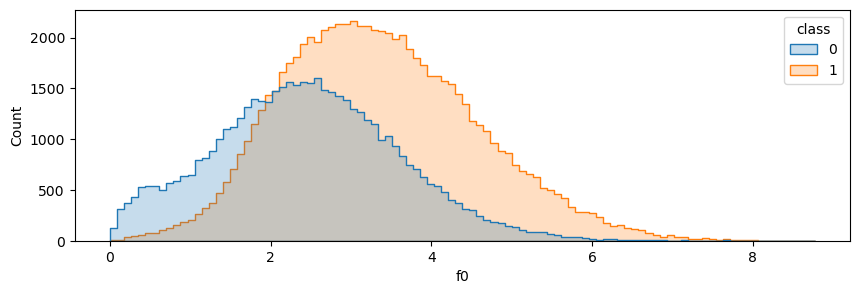

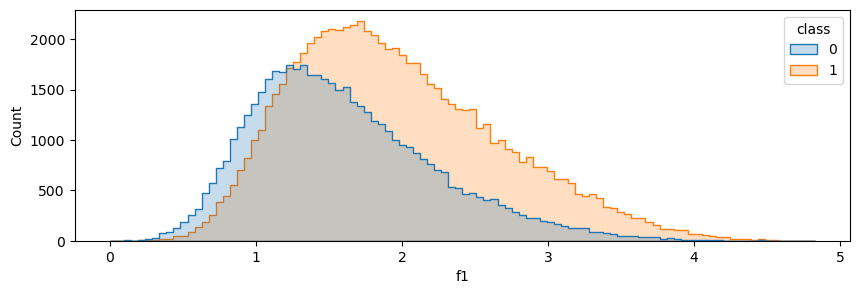

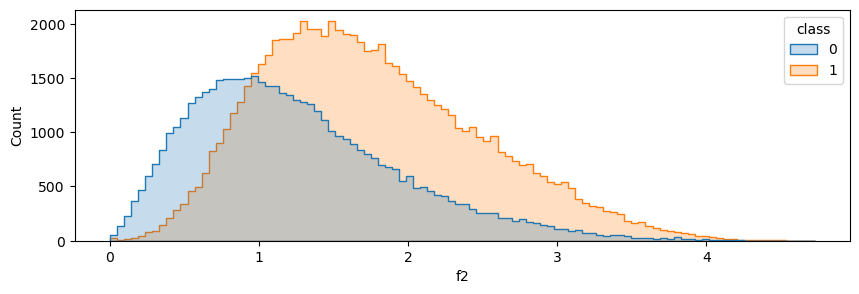

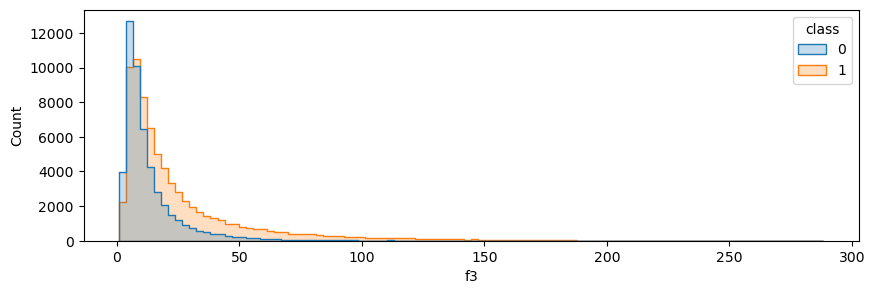

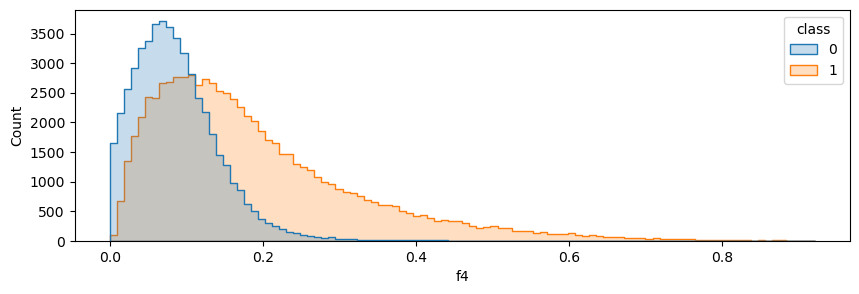

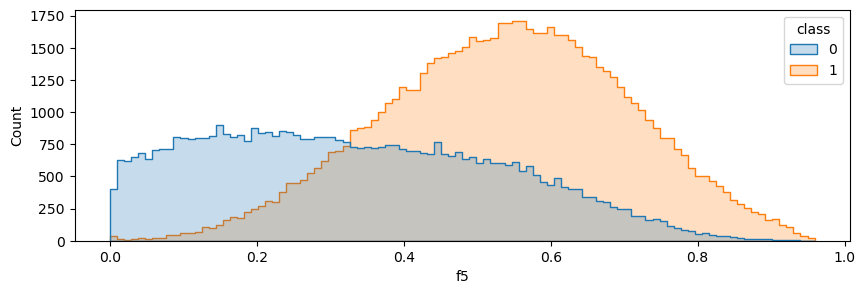

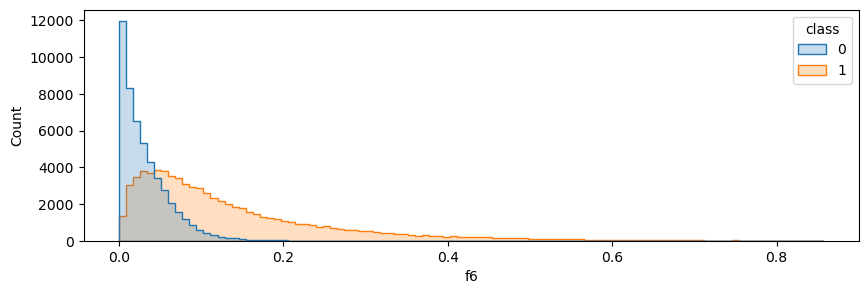

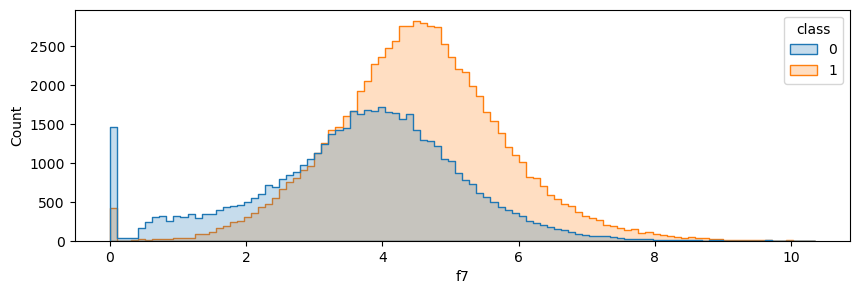

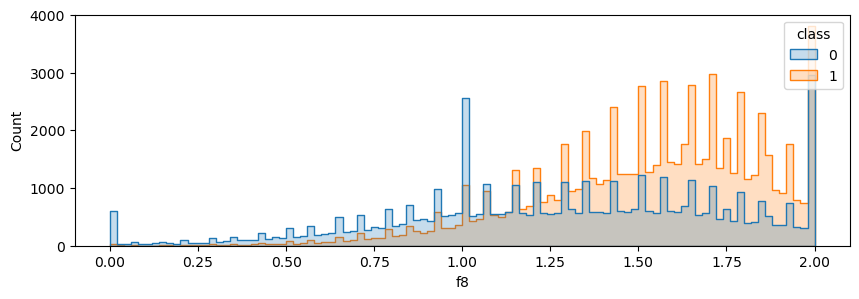

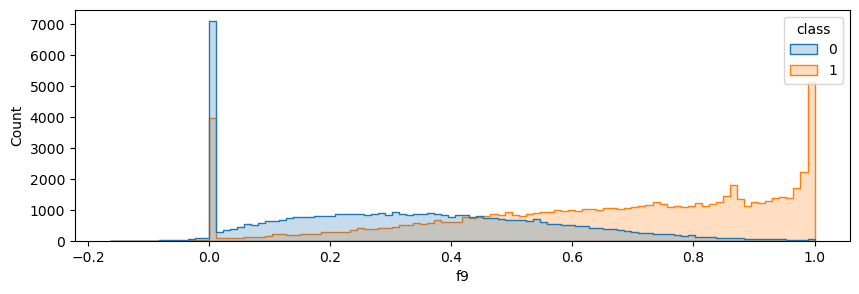

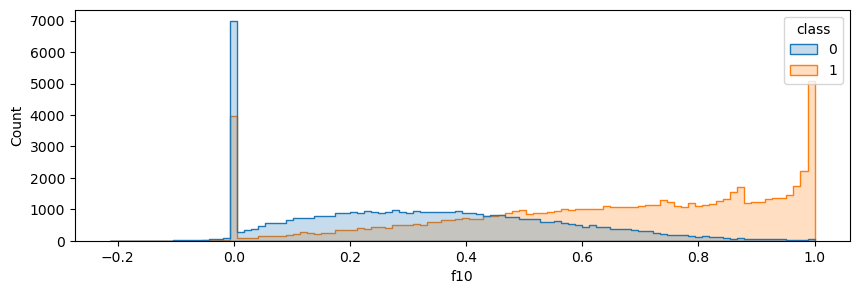

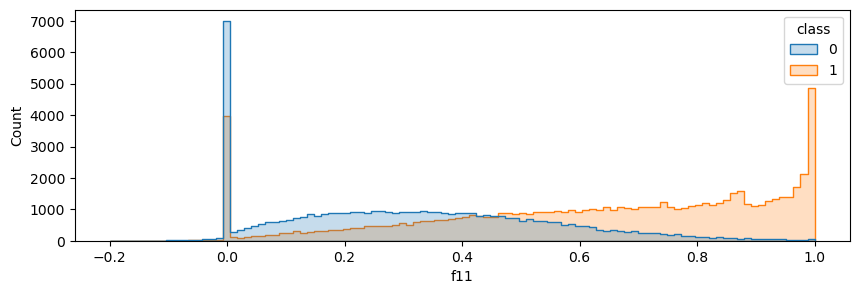

In [45]:
n_features = 12

for feature in [f'f{i}' for i in range(n_features)]:
    fig, ax = plt.subplots(figsize=(10,3))
    sns.histplot(data=feature_sig_df, x=feature, hue='class', bins=100, element='step')
    plt.show()


[[ 0.41875882  0.27491423  0.04876592 -0.14647627 -3.603192   -0.78340935
   8.3932487  -0.79137032  0.18170943  0.71641092  0.39434182  0.09247331]]
[ 2.99270939  1.81605299  1.55059098 20.70651981  0.14824355  0.45525489
  0.09375865  4.17304869  1.4260253   0.51439743  0.50651637  0.49794463]
[1.57582333e+00 4.86002185e-01 5.75864457e-01 5.88348741e+02
 1.46839315e-02 4.23830325e-02 1.13689671e-02 2.01410664e+00
 1.58700245e-01 9.42586444e-02 9.42647912e-02 9.44558672e-02]


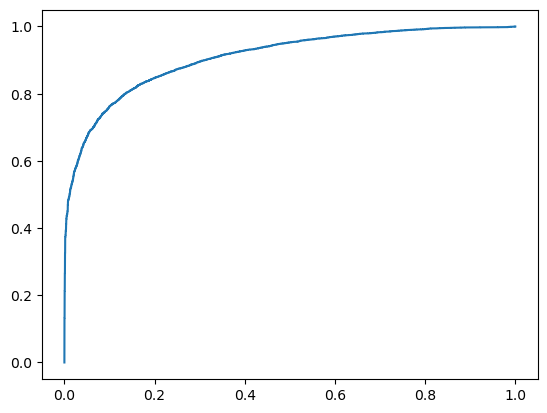

In [42]:
n_features = 12
feature_column = [f'f{i}' for i in range(n_features)]

# import standard scaler and logistic regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


# create train test split and train logistic regression model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_sig_df[feature_column], feature_sig_df['class'], test_size=0.1, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

clf.score(X_test, y_test)

# calulate AUC and plot ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

import matplotlib.pyplot as plt

plt.plot(fpr, tpr)

# calculate precision and recall
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# print standard scaler and logistic regression coefficients
print(clf.coef_)
print(scaler.mean_)
print(scaler.var_)

In [ ]:
for 